# Result comparaison for Superpixels Entropy

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import EntropyRateSuperpixel as ERS
import MyDataset as Data

from SSGA import SSGA

In [2]:
usedDataset = Data.IndianPines
#usedDataset = Data.PaviaUniversity
#usedDataset = Data.PaviaCenter

N,M,B = usedDataset["shape"]
N,M,B = usedDataset["data"].shape

def computePs(K):
    gamma = 0.15
    return int(N*M/K * 1/np.log(np.log(N*M/K)) * gamma)

## Finding $\lambda$ coefficient

In [3]:
def find_lambda_coeff(data, K, mini, maxi, similarity_function, Ps, print_info=False):
    def aux(i,j, SP):
        coeff = int((i+j)/2)
        if print_info:
            print("finding lambda coeff:", coeff)
        if i>=j:
            return SP, max(coeff,1)
        
        SP = ERS.find_superpixel(data, K, coeff, similarity_function)
        minSPsize = min([len(l) for l in SP])
        if minSPsize==Ps:
            return SP, coeff
        elif minSPsize<Ps:
            return aux(coeff+1, j, SP)
        else:
            return aux(i, coeff-1, SP)
        
    return aux(mini, maxi, None)

In [4]:
class Superpixel:
    def __init__(self, liste, labels, gt):
        self.pixels = [elt for elt in liste]
        self.guess = 0
        self.guess_count = 0

        for l in labels:
            guess_count = len(
                [i for i in range(len(self.pixels)) if gt[self.pixels[i]]==l]
            )
            if guess_count > self.guess_count:
                self.guess_count = guess_count
                self.guess = l
        
        self.proportion = 1
        self.isSingleClass = True
        if self.guess != 0:
            length = len([coor for coor in self.pixels if gt[coor]!=0])
            self.proportion = self.guess_count/length
            self.isSingleClass = self.guess_count == length
    
    

class SuperpixelClassifier:
    def __init__(self, liste, labels, gt):
        self.liste = liste
        self.SPs:list[Superpixel] = [Superpixel(l, labels, gt) for l in liste]
        self.association:dict[tuple[int,int], Superpixel] = {}
        self.guess_map = np.zeros(gt.shape, dtype=int)

        for i,SP in enumerate(self.SPs):
            for coor in SP.pixels:
                self.association[coor] = i
        n,m = gt.shape
        for x in range(n):
            for y in range(m):
                self.guess_map[x,y] = self.guess(x,y)

    
    def getSP(self, x,y):
        return self.SPs[self.association[(x,y)]]
    
    def guess(self, x,y):
        return self.getSP(x,y).guess

    def predict(self, liste):
        return [self.guess(coor) for coor in liste]
    
    def accuracy(self, samples, labels):
        assert len(samples)==len(labels)
        prediction = self.predict(samples)
        return len([i for i in range(len(samples)) if prediction[i]==labels[i]])
    
    def singleClassCount(self):
        return len([i for i in range(len(self.SPs)) if self.SPs[i].isSingleClass])
    
    def averageProportion(self):
        return np.average([SP.proportion for SP in self.SPs])
    
    def guessMap(self):
        return self.guess_map
    
    def overallAccuracy(self, gt):
        goodGuessCount = 0
        nonZeroCount = 0
        n,m = self.guess_map.shape
        for x in range(n):
            for y in range(m):
                if gt[x,y]!=0:
                    nonZeroCount+=1
                    if gt[x,y]==self.guess_map[x,y]:
                        goodGuessCount +=1
        assert nonZeroCount!=0
        return goodGuessCount/nonZeroCount

### Comparing function

Superpixel computation time + SSGA computation times
Average SSGA final fitness function score
OA of SP classifier models
Number of 1-class SP
average proportion of max_amount/amount

## Comparing data change

In [5]:
Ks = [100*i for i in range(1,8)]
ClassifierDic = {}

In [6]:
# Comparing data format
data1 = usedDataset["data"].copy()
data2 = Data.normalized_data(usedDataset["data"].copy())
data3 = Data.standardize_data( usedDataset["data"].copy() )
datas = [data1, data2, data3]
names = ["Basic", "Normalized", "Standardized"]


if False:
    Ks = [100*i for i in range(1,8)]
    ClassifierDic = {}

    # Values found with find_lambda_coeff function
    IndianLambdaCoeffDatas = {
        100:[1, 17, 34],
        200:[1, 33, 72],
        300:[1, 52, 110],
        400:[1, 59, 150],
        500:[1, 78, 187],
        600:[1, 94, 230],
        700:[1, 133, 275]
    }
    UniversityLambdaCoeffDatas = {
        100:[1, 17, 42],
        200:[1, 32, 84],
        300:[1, 47, 123],
        400:[1, 60, 166],
        500:[1, 81, 210],
        600:[1, 97, 251],
        700:[1, 111, 300]
    }
    
    for K in Ks:
        print("K:", K)
        Ps = computePs(K)
        SPClassifiers:list[SuperpixelClassifier] = []
        for i,data in enumerate(datas):
            print(i, end=" ")
            SPs, coeff = find_lambda_coeff(data, K, 1, 350, ERS.complete_basic_similarity, Ps)
            print("Choosen Coef:", coeff)
            #SPs = ERS.find_superpixel(data, K, IndianLambdaCoeffDatas[K][i], ERS.complete_basic_similarity, True)
            SPClassifiers.append(SuperpixelClassifier(SPs, usedDataset["labels"], usedDataset["gt"]))
        print()
        ClassifierDic[K] = SPClassifiers

In [ ]:
similarity_functions = [ERS.complete_basic_similarity,
                        ERS.complete_norm_similarity,
                        ERS.complete_norm_similarity_v2]
names = ["Basic", "(.)²", "|.|"]


if True:
    trainData = Data.standardize_data(usedDataset["data"])
    ClassifierDic = {}

    # Values found with find_lambda_coeff function
    IndianLambdaCoeffDatas = {
        50: [17, 27, 15],
        100:[34, 58, 31],
        200:[72, 114, 70],
        300:[110, 179, 102],
        400:[150, 242, 141],
        500:[187, 308, 180],
        600:[230, 379, 217]
    }
    UniversityLambdaCoeffDatas = {
        100:[42],
        200:[84],
        300:[123],
        400:[166],
        500:[210],
        600:[251],
        700:[300]
    }

    Ks = list(IndianLambdaCoeffDatas.keys())
    for K in Ks:
        print("K:", K)
        Ps = computePs(K)
        SPClassifiers:list[SuperpixelClassifier] = []

        for i,simFun in enumerate(similarity_functions):
            print(i, end=" ")
            #SPs, coeff = find_lambda_coeff(trainData, K, 1, 100, simFun, Ps)
            #print("Choosen Coef:", coeff)
            SPs = ERS.find_superpixel(trainData, K, IndianLambdaCoeffDatas[K][i], simFun, True)
            SPClassifiers.append(SuperpixelClassifier(SPs, usedDataset["labels"], usedDataset["gt"]))
        print()
        ClassifierDic[K] = SPClassifiers

K: 50
0 1 

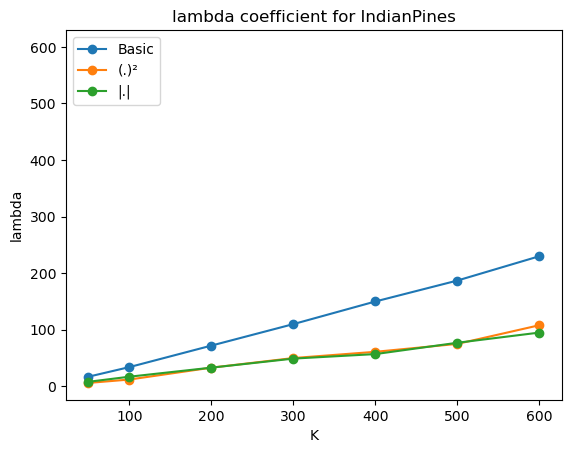

In [11]:
for i in range(len(similarity_functions)):
    plt.plot(Ks, [IndianLambdaCoeffDatas[K][i] for K in Ks], "-o", label=names[i])
plt.plot(600,600, "")
plt.xlabel("K")
plt.ylabel("lambda")
plt.title("lambda coefficient for IndianPines")
plt.legend()
plt.show()

### Visual result

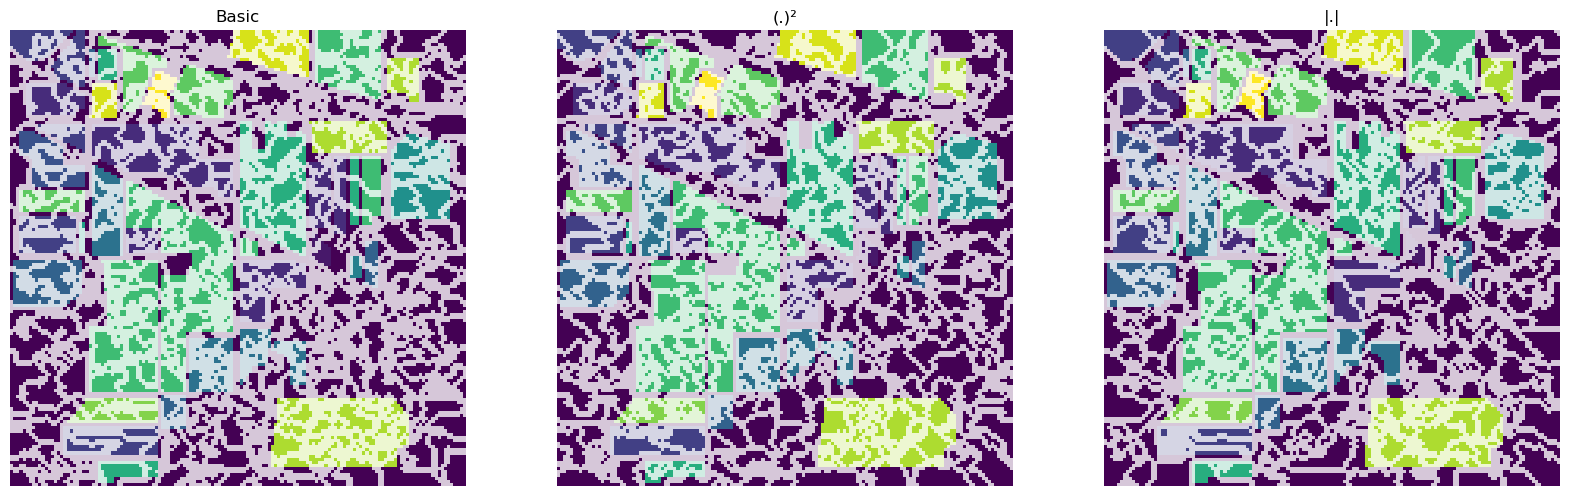

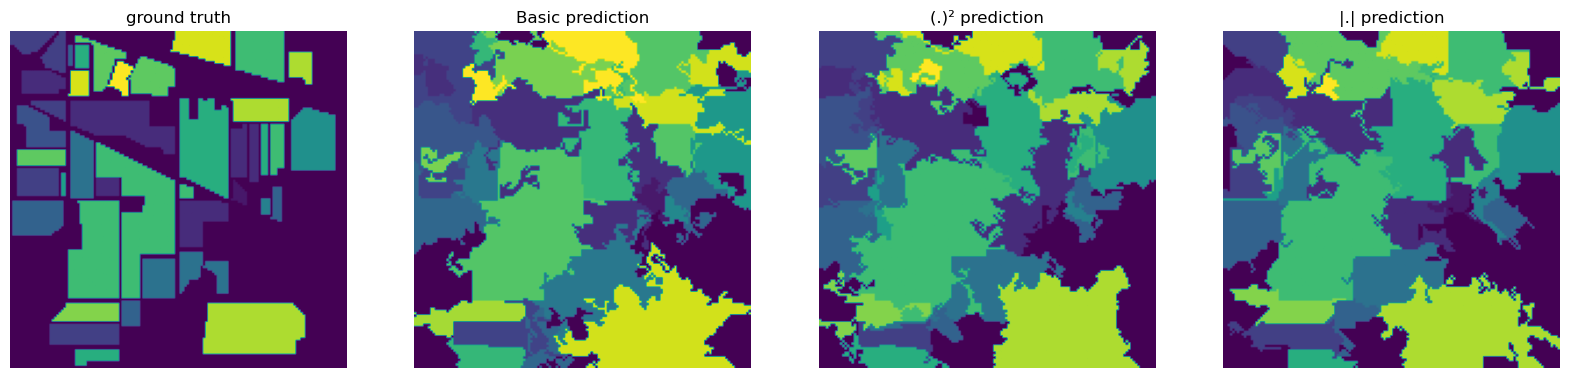

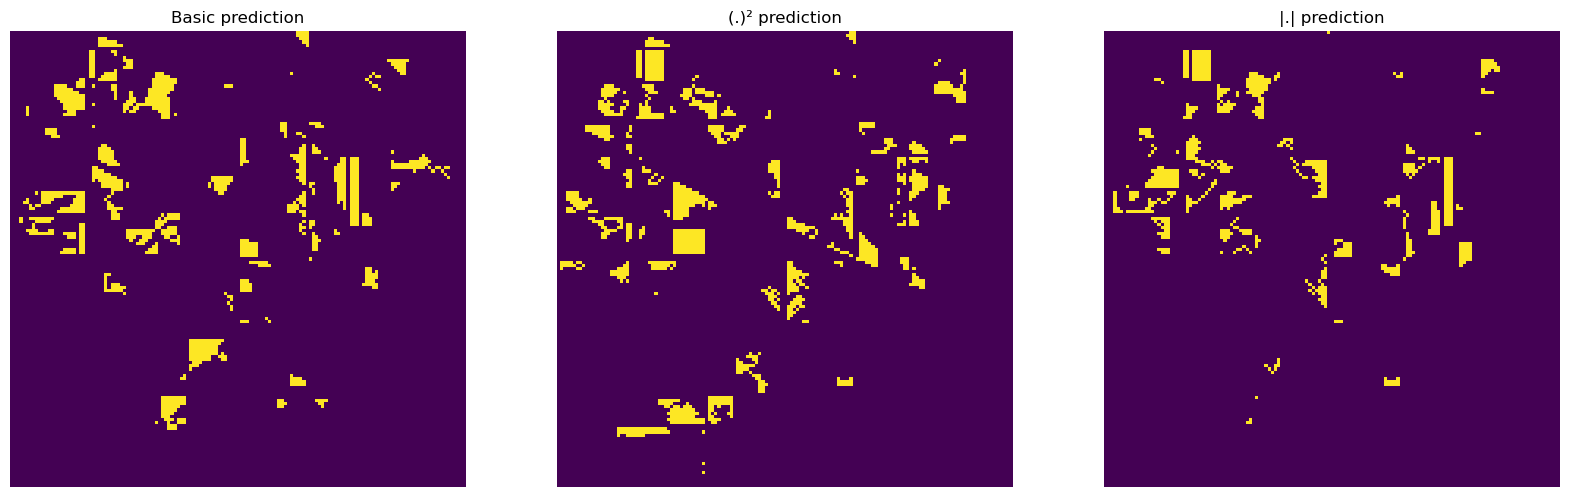

In [16]:
K =  200
SPClassifiers = ClassifierDic[K]
fig, axs = plt.subplots(1, len(SPClassifiers))
fig.set_size_inches(20,30)
for i,C in enumerate(SPClassifiers):
    axs[i].imshow(usedDataset["gt"])
    axs[i].imshow(ERS.create_overlay_borders(usedDataset["gt"], C.liste, color=[255,255,255,200]))
    axs[i].title.set_text(names[i])
    axs[i].axis("off")
plt.show()


fig, axs = plt.subplots(1, len(SPClassifiers)+1)
fig.set_size_inches(20,30)
imgs = [usedDataset["gt"]] + [C.guessMap() for C in SPClassifiers]
titles = ["ground truth"] + [name+" prediction" for name in names]

for i in range(len(imgs)):
    axs[i].imshow(imgs[i])
    axs[i].title.set_text(titles[i])
    axs[i].axis("off")
plt.show()


fig, axs = plt.subplots(1, len(SPClassifiers))
fig.set_size_inches(20,30)
for i in range(1, len(imgs)):
    new_img = np.zeros((N,M))
    for x in range(N):
        for y in range(M):
            if usedDataset["gt"][x,y]!=0 and usedDataset["gt"][x,y]!=imgs[i][x,y]:
                new_img[x,y] = 1
    axs[i-1].imshow(new_img)
    axs[i-1].title.set_text(titles[i])
    axs[i-1].axis("off")
plt.show()


### Classification result

In [89]:
size = len(ClassifierDic[Ks[0]])
overallAccuracys = {K:[0 for _ in range(size)] for K in Ks}
singleClassCounts = {K:[0 for _ in range(size)] for K in Ks}
averageProportions = {K:[0 for _ in range(size)] for K in Ks}

for K in Ks:
    for i,C in enumerate(ClassifierDic[K]):
        overallAccuracys[K][i] = C.overallAccuracy(usedDataset["gt"])
        singleClassCounts[K][i] = C.singleClassCount()
        averageProportions[K][i] = C.averageProportion()
        

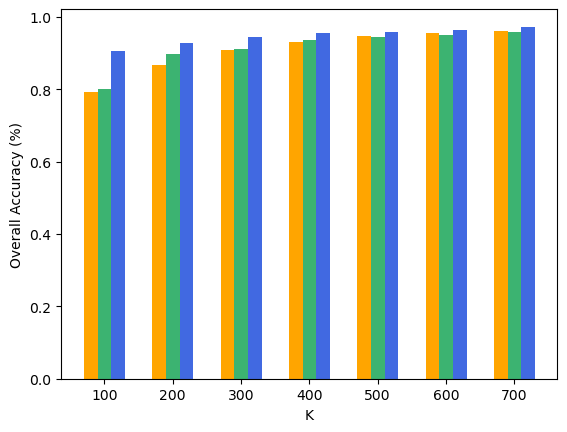

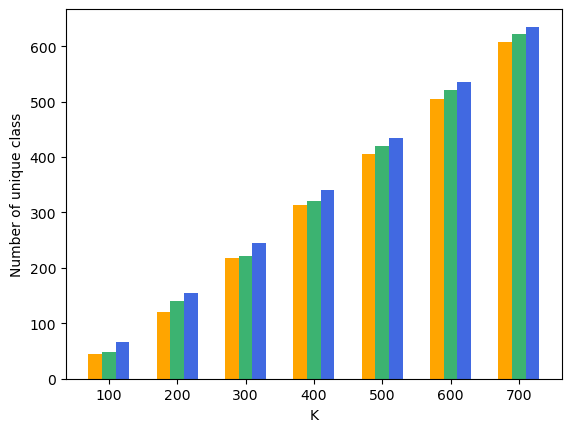

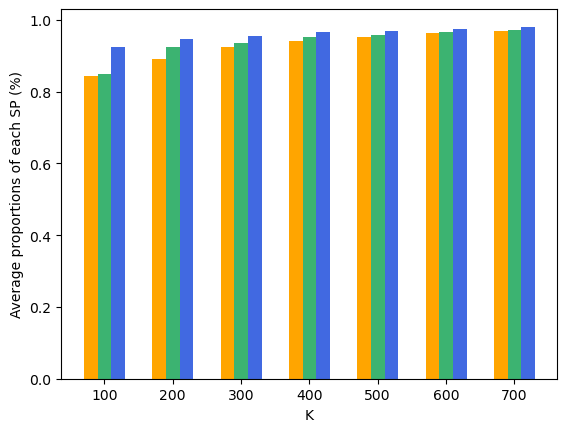

In [90]:
colors = ["orange", "mediumseagreen", "royalblue"]
def plot_info(info, ylabel=""):
    for k,K in enumerate(Ks):
        for d in range(size):
            plt.bar(K+ d*20 -20, info[K][d], color=colors[d], width=20)
    plt.xlabel("K")
    plt.ylabel(ylabel)
    plt.show()

plot_info(overallAccuracys, "Overall Accuracy (%)")
plot_info(singleClassCounts, "Number of unique class")
plot_info(averageProportions, "Average proportions of each SP (%)")

### Time result

In [ ]:
import time

class Param:
    GN = 100
    NP = 100
    Pc = 0.9
    Pm1 = 0.02
    Pm2 = 0.1


SPs_time = {K:[0 for _ in range(len(datas))] for K in Ks}
SSGA_time = {K:[0 for _ in range(len(datas))] for K in Ks}
best_fitness = {K:[0 for _ in range(len(datas))] for K in Ks}

A = 1
for K in Ks:
    print("K:", K)
    for i,data in enumerate(datas):
        for _ in range(A):
            start_time = time.time()
            SPs = ERS.find_superpixel(data, K, UniversityLambdaCoeffDatas[K][i], ERS.complete_basic_similarity, True)
            end_time = time.time()
            SPs_time[K][i] += end_time - start_time

            start_time = time.time()
            pop, fitness = SSGA(data, 9, K, Param.GN, Param.NP, Param.Pc, Param.Pm1, Param.Pm2, False, SP=SPs)
            end_time = time.time()
            SSGA_time[K][i] += end_time - start_time
            best_fitness[K][i] += fitness[0]
        
        SPs_time[K][i] /= A
        SSGA_time[K][i] /= A
        best_fitness[K][i] /= A

K: 100
K: 200
K: 300
K: 400
K: 500
K: 600
K: 700


In [73]:
print(SPs_time)
print(SSGA_time)
print(best_fitness)

{100: [10.692700862884521, 9.697648048400879, 9.004975080490112], 200: [9.445805788040161, 10.824516773223877, 9.774529695510864], 300: [9.545434713363647, 10.7208092212677, 9.916143655776978], 400: [9.229990482330322, 11.50728440284729, 10.779298543930054], 500: [8.982416868209839, 10.320045709609985, 10.094208002090454], 600: [8.477921962738037, 11.339497566223145, 10.252572059631348], 700: [8.04901671409607, 10.851320266723633, 10.928387641906738]}
{100: [2.7420356273651123, 2.492100954055786, 2.7677788734436035], 200: [2.5874111652374268, 3.093327522277832, 2.8952524662017822], 300: [2.666292190551758, 2.435565710067749, 2.8165204524993896], 400: [3.077873468399048, 2.742413282394409, 2.8139145374298096], 500: [2.9696226119995117, 2.6409835815429688, 2.443225622177124], 600: [3.043376922607422, 2.791020631790161, 2.7960140705108643], 700: [2.773719310760498, 2.6540701389312744, 3.0260767936706543]}
{100: [0.564900801139824, 0.6700809343838839, 0.7393010052240507], 200: [0.647883284

{100: [10.692700862884521, 9.697648048400879, 9.004975080490112], 200: [9.445805788040161, 10.824516773223877, 9.774529695510864], 300: [9.545434713363647, 10.7208092212677, 9.916143655776978], 400: [9.229990482330322, 11.50728440284729, 10.779298543930054], 500: [8.982416868209839, 10.320045709609985, 10.094208002090454], 600: [8.477921962738037, 11.339497566223145, 10.252572059631348], 700: [8.04901671409607, 10.851320266723633, 10.928387641906738]}

{100: [2.7420356273651123, 2.492100954055786, 2.7677788734436035], 200: [2.5874111652374268, 3.093327522277832, 2.8952524662017822], 300: [2.666292190551758, 2.435565710067749, 2.8165204524993896], 400: [3.077873468399048, 2.742413282394409, 2.8139145374298096], 500: [2.9696226119995117, 2.6409835815429688, 2.443225622177124], 600: [3.043376922607422, 2.791020631790161, 2.7960140705108643], 700: [2.773719310760498, 2.6540701389312744, 3.0260767936706543]}

{100: [0.564900801139824, 0.6700809343838839, 0.7393010052240507], 200: [0.647883284355866, 0.7732146542294418, 0.8355649330310471], 300: [0.711928252130091, 0.7918464795046569, 0.84757043129747], 400: [0.7315903055051772, 0.8247767741744884, 0.88854362096494], 500: [0.7803511774918824, 0.828399834405302, 0.8930534182039617], 600: [0.7826777936616738, 0.8610360652046352, 0.8849423910323988], 700: [0.8123070428393724, 0.8669709352875258, 0.8904057407446652]}

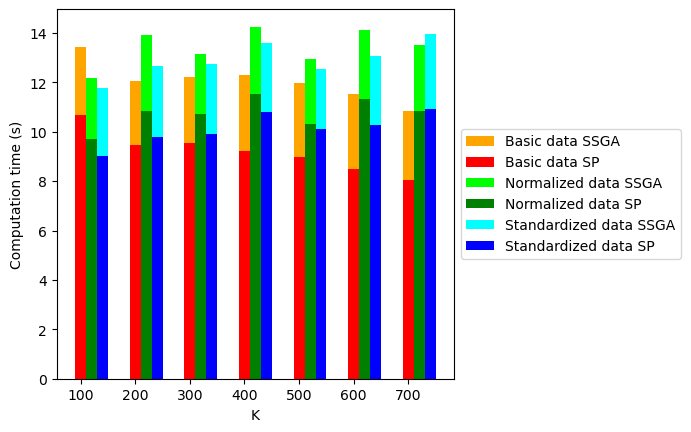

In [106]:
SP_colors = ["red", "green", "blue"]
SSGA_colors = ["orange", "lime", "cyan"]


fig = plt.figure()
ax = plt.subplot(111)
for k,K in enumerate(Ks):
    for d,data in enumerate(datas):
        if k==0:
            ax.bar(K+d*20, SPs_time[K][d]+SSGA_time[K][d], width=20, color=SSGA_colors[d], label=names[d]+" data SSGA")
            ax.bar(K+ d*20, SPs_time[K][d], color=SP_colors[d], width=20, label=names[d]+" data SP")
        else:
            ax.bar(K+d*20, SPs_time[K][d]+SSGA_time[K][d], width=20, color=SSGA_colors[d])
            ax.bar(K+ d*20, SPs_time[K][d], color=SP_colors[d], width=20)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel("K")
plt.ylabel("Computation time (s)")
plt.show()